In [1]:
# ======================================
# 0. 기본 라이브러리
# ======================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from bs4 import BeautifulSoup
import requests
import openpyxl
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
import time
from selenium.webdriver.common.by  import By
from selenium.webdriver.common.keys import Keys

from pathlib import Path
import shutil
from datetime import datetime

import matplotlib.font_manager as fm
from matplotlib import rcParams


# ======================================
# 1. 스타일 먼저 (중요: 폰트보다 먼저)
# ======================================
plt.style.use('_mpl-gallery-nogrid')   # matplotlib 스타일
sns.set_theme(style="white")           # seaborn 기본 테마

# ======================================
# 2. 폰트 설정 (나눔고딕)
# ======================================
FONT_PATH = r"E:\seoul_pv_load_analysis\fonts\NanumGothic.ttf"

# matplotlib에 폰트 등록
fm.fontManager.addfont(FONT_PATH)

# 전역 폰트 지정
rcParams["font.family"] = "NanumGothic"

# 마이너스 깨짐 방지
rcParams["axes.unicode_minus"] = False

# (선택) 기본 폰트 사이즈 살짝 키우기
rcParams["font.size"] = 12
rcParams["axes.titlesize"] = 18
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12

# ======================================
# 3. 개별 객체용 폰트 (pie, title 등)
# ======================================
font_prop = fm.FontProperties(fname=FONT_PATH)

# ======================================
# 4. seaborn스타일 설정
# ======================================
sns.set_style("ticks") # 스타일 테마 설정
sns.set_context("notebook") # 문맥에 따라 스타일 크기 조정
sns.set_palette("pastel")

### DAY 3: 태양광 이론적 시간대 발전 패턴 생성

**목적**
- 실제 발전량이 아닌 시간대 패턴 중심의 태양광 발전 특성 정의

**주요 작업**
- 정오 중심의 이론적 PV 발전 곡선 생성
- 부하 패턴과 비교 가능하도록 정규화

**산출물**
- 태양광 시간대 발전 패턴 곡선

In [ ]:
'''
Day 3 — 목표

Day 3에서는 태양광 발전을 절대량이 아닌 ‘시간대 분포 구조’로 해석하고,  
전력 부하와의 시간대 불일치 구조를 비교·분석할 수 있는 이론적 PV 기준 패턴을 구축한다.

'''

In [2]:
# 1. 데이터 로드 + Day1 로직으로 datetime/value 생성 → df_base 확정

# ------------------------------------------------------------
# 입력 데이터 확보 (최종본)
# - CWD: .../notebooks 기준
# - 데이터 위치: PROJECT_ROOT/data/법정동별시간별전력사용량.csv
# - 원본에 datetime/value 없으면 Day1 로직으로 생성
# ------------------------------------------------------------

PROJECT_ROOT = Path.cwd().parent          # .../seoul_pv_load_analysis
DATA_DIR = PROJECT_ROOT / "data"
LOAD_FILE = DATA_DIR / "법정동별시간별전력사용량.csv"
OUT_DIR = PROJECT_ROOT / "outputs"
OUT_DIR.mkdir(exist_ok=True)

print("CWD:", Path.cwd())
print("PROJECT_ROOT:", PROJECT_ROOT)
print("CSV exists?", LOAD_FILE.exists())
print("CSV path:", LOAD_FILE)

if not LOAD_FILE.exists():
    raise FileNotFoundError(f"데이터 파일을 찾을 수 없습니다: {LOAD_FILE}")

# 인코딩 자동 시도
encodings_to_try = ["utf-8-sig", "utf-8", "cp949", "euc-kr"]
df = None
last_error = None
for enc in encodings_to_try:
    try:
        df = pd.read_csv(LOAD_FILE, encoding=enc)
        print(f"✅ CSV 로드 성공 (encoding={enc}) | shape={df.shape}")
        break
    except Exception as e:
        last_error = e

if df is None:
    raise RuntimeError(f"CSV 로드 실패. 마지막 에러: {last_error}")

# --- Day1 로직 반영: datetime 생성 (없을 때)
if "datetime" not in df.columns:
    # Day1 전제 컬럼 체크
    required = {"USE_YM", "USE_HM"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"df에 datetime이 없고, {missing} 컬럼도 없습니다. 컬럼명을 확인해주세요.")
    
    df["date"] = pd.to_datetime(df["USE_YM"], format="%Y%m%d", errors="coerce")
    # ✅ Day1과 동일하게 -1 적용 (일관성 유지)
    df["hour"] = (df["USE_HM"] // 100 - 1).astype("Int64")
    df["datetime"] = df["date"] + pd.to_timedelta(df["hour"].fillna(0), unit="h")

# --- month/hour 파생 (혹시 없으면 생성)
df["datetime"] = pd.to_datetime(df["datetime"])
df["month"] = df["datetime"].dt.month
df["hour"] = df["datetime"].dt.hour

# --- value 생성 (없을 때)
if "value" not in df.columns:
    if "FDRCT_VLD_KWH" not in df.columns:
        raise ValueError("df에 value도 없고 FDRCT_VLD_KWH도 없습니다. 전력 사용량 컬럼명 확인 필요.")
    df["value"] = pd.to_numeric(
        df["FDRCT_VLD_KWH"].astype(str).str.replace(",", ""),
        errors="coerce"
    )

# --- Day1 최소 테이블 확정
df_base = df[["datetime", "month", "hour", "value"]].copy()

print("df_base:", df_base.shape)
display(df_base.head())
print("hour 범위:", int(df_base["hour"].min()), "~", int(df_base["hour"].max()))
print("value 결측률(%):", round(df_base["value"].isna().mean() * 100, 4))


CWD: e:\seoul_pv_load_analysis\notebooks
PROJECT_ROOT: e:\seoul_pv_load_analysis
CSV exists? True
CSV path: e:\seoul_pv_load_analysis\data\법정동별시간별전력사용량.csv
✅ CSV 로드 성공 (encoding=utf-8-sig) | shape=(9754804, 5)
df_base: (9754804, 4)


,datetime,month,hour,value
0,2022-06-28,6,0,10782.0565
1,2022-06-28,6,0,11394.8635
2,2022-06-28,6,0,7273.9620
3,2022-06-28,6,0,11008.8110
4,2022-06-28,6,0,2905.1120


hour 범위: 0 ~ 23
value 결측률(%): 0.0


In [3]:
# 2. DAY 2 핵심 산출물 재구성: 24시간 평균 부하 프로파일

# 24시간 평균 부하 프로파일(DAY 2 산출물 역할)
load_profile_24h = (df_base.dropna(subset = ["value"]).groupby("hour", as_index = False)["value"]
                    .agg(load_mean = "mean", load_std = "std").sort_values("hour"))

peak_hour = int(load_profile_24h.loc[load_profile_24h["load_mean"].idxmax(), "hour"])
load_peak = float(load_profile_24h["load_mean"].max())

print("peak_hour =", peak_hour, "| load_peak =", load_peak)
display(load_profile_24h)

peak_hour = 13 | load_peak = 7647.383917127698


,hour,load_mean,load_std
0,0,4828.966546,15855.283528
1,1,4436.061656,14999.609193
2,2,4301.931715,15795.194031
3,3,4069.172541,13469.363720
4,4,4467.956892,28206.642910
5,5,4570.492076,26689.943413
6,6,5000.093613,16905.561280
7,7,5677.409920,16451.921541
8,8,6575.992184,18452.542962
9,9,7246.801206,26311.111687


In [4]:
# 3. PV 이론 패턴 함수 (정규화 0 ~ 1) + 계절 훅 포함

def season_from_month(month: int) -> str:
    if month in [12, 1, 2]:
        return "winter"
    if month in [3, 4, 5]:
        return "spring"
    if month in [6, 7, 8]:
        return "summer"
    return "fall"

def pv_params_by_season(season: str):
    # 서울 기준 "합리적 근사값"
    params = {
        "winter": dict(sunrise = 8, sunset = 17, peak = 12, sigma = 1.8),
        "spring": dict(sunrise = 7, sunset = 19, peak = 13, sigma = 2.2),
        "summer": dict(sunrise = 5, sunset = 20, peak = 13, sigma = 2.6),
        "fall": dict(sunrise = 7, sunset = 18, peak = 12, sigma = 2.1),
    }
    return params[season]

def make_pv_profile(hours = range(24), month = None, sunrise = None, sunset = None, peak = None, sigma = None):
    '''
    반환: DataFrame(hour, pv_norm)
    - pv_norm: 0 ~ 1 정규화된 pv 이론 패턴
    - day light(일출 ~ 일몰) 밖은 0
    '''
    hours = np.array(list(hours), dtype = int)

    # month 입력 시 계절 파라미터 자동 적용 (확장 훅)
    if month is not None and (sunrise is None or sunset is None or peak is None or sigma is None):
        s = season_from_month(int(month))
        p = pv_params_by_season(s)
        sunrise, sunset, peak, sigma = p["sunrise"], p["sunset"], p["peak"], p["sigma"]

    # 기본값
    sunrise = 7 if sunrise is None else sunrise
    sunset = 19 if sunset is None else sunset
    peak = 13 if peak is None else peak
    sigma = 2.3 if sigma is None else sigma

    # 가우시안 종모양
    pv = np.exp(-0.5 * ((hours - peak) / sigma) ** 2)

    # 일출 ~ 일몰 밖은 0
    pv[(hours < sunrise)|(hours > sunset)] = 0.0

    # 정규화
    if pv.max() > 0:
        pv = pv / pv.max()
    
    return pd.DataFrame({"hour": hours, "pv_norm": pv})

In [5]:
# 4. PV 프로파일 생성 + 검증

pv_profile_24h = make_pv_profile() # 기본 (봄 / 가을 근사)
display(pv_profile_24h)

# 필수 검증
assert pv_profile_24h["pv_norm"].min() >= 0, "pv_norm min < 0"
assert pv_profile_24h["pv_norm"].max() <= 1.0000001, "pv_norm max > 1"
print("pv_norm 검증 통과 (0 ~ 1)")

,hour,pv_norm
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
5,5,0.000000
6,6,0.000000
7,7,0.033285
8,8,0.094142
9,9,0.220405


pv_norm 검증 통과 (0 ~ 1)


In [6]:
# 5. 시나리오 스케일링(PV 피크를 부하 피크의 X% 로)

def scale_pv_to_load(pv_profile_24h: pd.DataFrame, load_peak: float, pv_capacity_ratio: float) -> pd.DataFrame:
    '''
    pv_capacity_ratio: PV 피크를 부하 피크의 몇 %로 볼지 (0.1 = 10%, 0.2 = 20%,...)
    반환: pv_kW 컬럼이 추가된 DF
    '''
    out = pv_profile_24h.copy()
    out["pv_kW"] = out["pv_norm"] * (load_peak * pv_capacity_ratio)
    return out

pv_ratio = 0.2 # 대표 시나리오 (20%)
pv_scale_24h = scale_pv_to_load(pv_profile_24h, load_peak = load_peak, pv_capacity_ratio = pv_ratio)
display(pv_scale_24h)

,hour,pv_norm,pv_kW
0,0,0.000000,0.000000
1,1,0.000000,0.000000
2,2,0.000000,0.000000
3,3,0.000000,0.000000
4,4,0.000000,0.000000
5,5,0.000000,0.000000
6,6,0.000000,0.000000
7,7,0.033285,50.908733
8,8,0.094142,143.988297
9,9,0.220405,337.104729


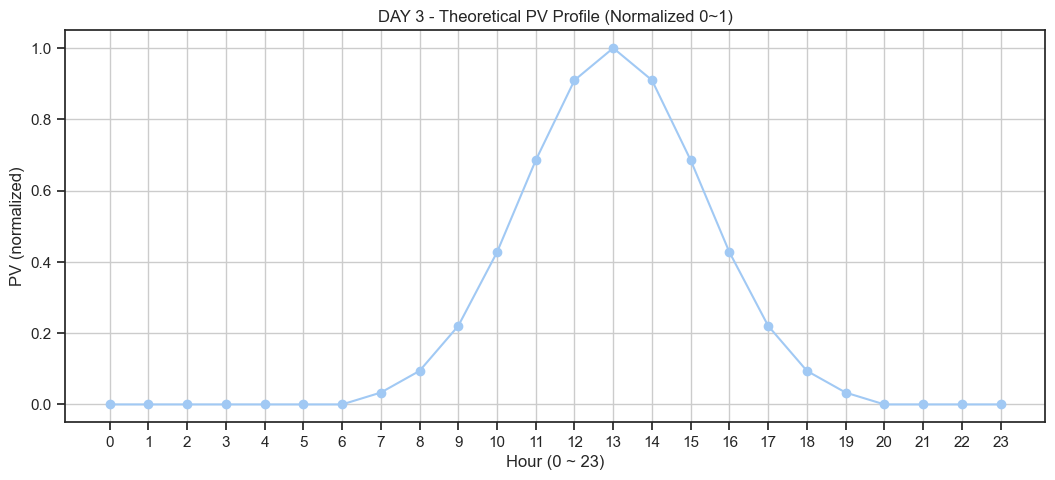

In [7]:
# 6. 병합테이블 + 시각화 2장

# (A) PV 정규화 곡선
plt.figure(figsize = (10, 4))
plt.plot(pv_profile_24h["hour"], pv_profile_24h["pv_norm"], marker = "o")
plt.title("DAY 3 - Theoretical PV Profile (Normalized 0~1)")
plt.xlabel("Hour (0 ~ 23)")
plt.ylabel("PV (normalized)")
plt.xticks(np.arange(0, 24, 1))
plt.grid(True)
plt.show()

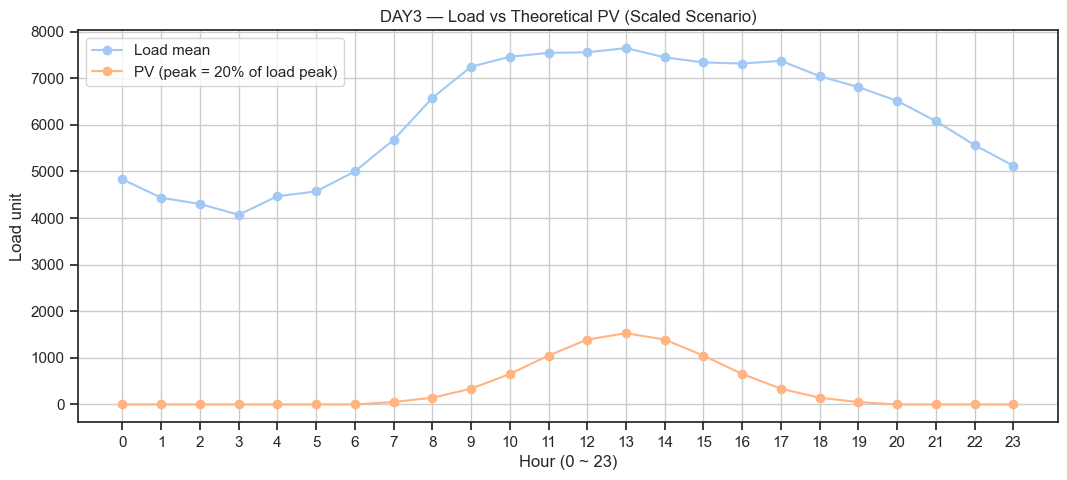

,hour,load_mean,load_std,pv_norm,pv_kW
0,0,4828.966546,15855.283528,0.0,0.0
1,1,4436.061656,14999.609193,0.0,0.0
2,2,4301.931715,15795.194031,0.0,0.0
3,3,4069.172541,13469.363720,0.0,0.0
4,4,4467.956892,28206.642910,0.0,0.0


In [8]:
# (B) 평균 부하 VS PV (스케일 20%)
merged = (load_profile_24h.merge(pv_scale_24h, on = "hour", how = "left").sort_values("hour"))

plt.figure(figsize = (10, 4))
plt.plot(merged["hour"], merged["load_mean"], marker = "o", label = "Load mean")
plt.plot(merged["hour"], merged["pv_kW"], marker = "o", label = f"PV (peak = {int(pv_ratio * 100)}% of load peak)")
plt.title("DAY3 — Load vs Theoretical PV (Scaled Scenario)")
plt.xlabel("Hour (0 ~ 23)")
plt.ylabel("Load unit")
plt.xticks(np.arange(0, 24, 1))
plt.grid(True)
plt.legend()
plt.show()

display(merged.head())

In [9]:
# 7. DAY 3 결론

print("===DAY 3 Conclusion===")
print("1) 실제 pv 발전량 대신, 시간대 구조 비교를 위한 이론적 pv 패턴(pv_norm, 0 ~ 1)을 생성했다.")
print("2) pv_norm은 일출 ~ 일몰 외 시간대를 0으로 처리했고, 최대값 1로 정규화 했다.")
print(f"3) 시나리오 스케일링으로 PV 피크를 부하 피크의 {int(pv_ratio * 100)}%로 맞춘 pv_KW를 구성했다.")
print("4) DAY 4에서는 net_load = load_mean - pv_kW를 기반으로 덕 커브(시간대 불일치) 지표를 계산한다.")

===DAY 3 Conclusion===
1) 실제 pv 발전량 대신, 시간대 구조 비교를 위한 이론적 pv 패턴(pv_norm, 0 ~ 1)을 생성했다.
2) pv_norm은 일출 ~ 일몰 외 시간대를 0으로 처리했고, 최대값 1로 정규화 했다.
3) 시나리오 스케일링으로 PV 피크를 부하 피크의 20%로 맞춘 pv_KW를 구성했다.
4) DAY 4에서는 net_load = load_mean - pv_kW를 기반으로 덕 커브(시간대 불일치) 지표를 계산한다.


In [10]:
# Day 3 output: theoretical PV profile
day3_out = pv_profile_24h.copy()

day3_out.to_csv(
    OUT_DIR / "DAY3_pv_theoretical_profile.csv",
    index=False,
    encoding="utf-8-sig"
)

print("Saved: outputs/DAY3_pv_theoretical_profile.csv")

Saved: outputs/DAY3_pv_theoretical_profile.csv
